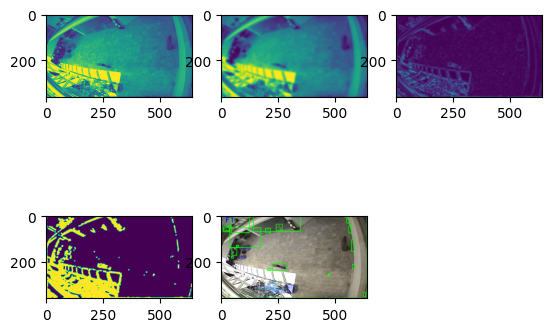

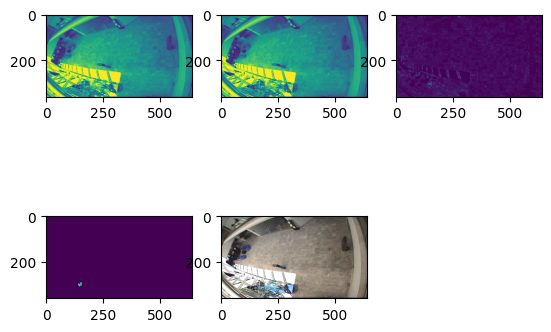

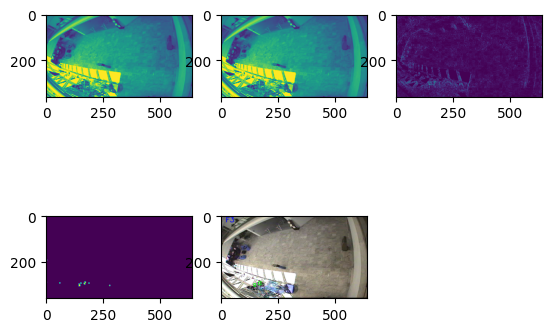

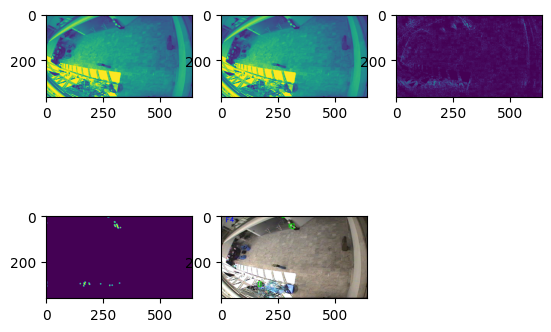

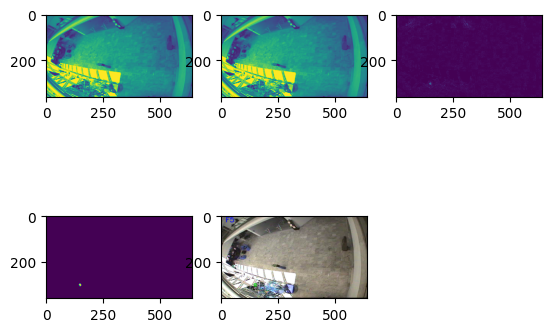

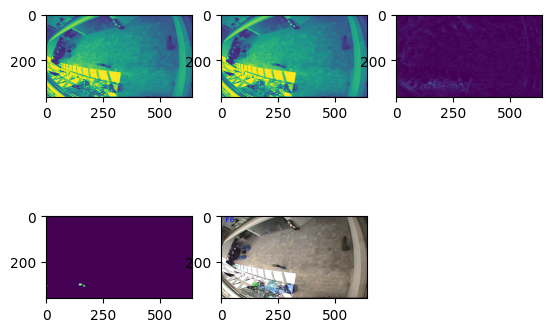

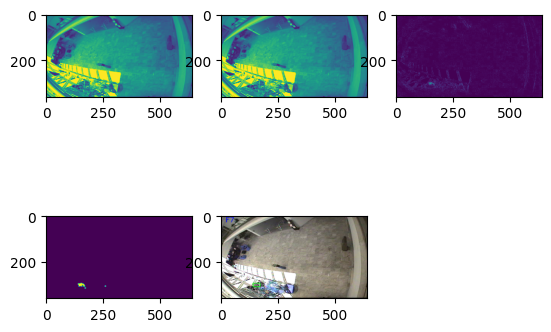

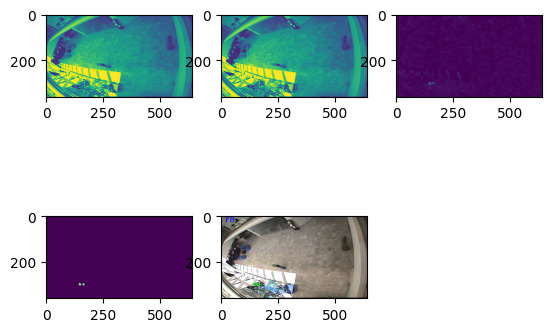

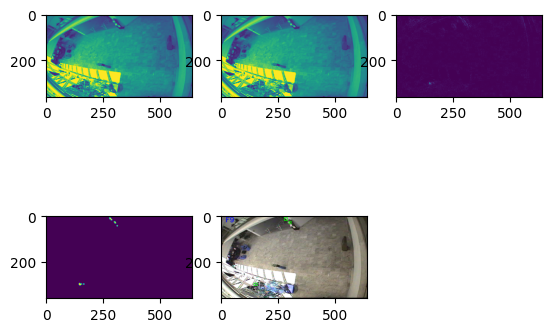

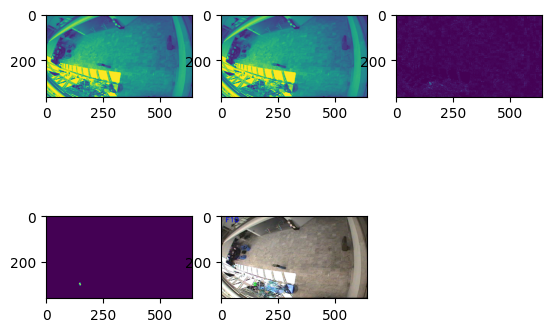

In [8]:
import cv2  # 导入opencv-python
import matplotlib.pyplot as plt  # 用于可视化图像帧
# 遍历视频的每一帧，将其灰度化的图像与前一帧比较，找出运动物体的像素块
vc = cv2.VideoCapture("Walk1.mpg")  # 导入的视频数据所在路径
# 读取初始帧，并对其进行预处理
firstFrame = vc.read()[1]  # vc.read()返回一个tuple类型的变量，包含两个元素，第二个元素表示读取的图像帧
firstFrame = cv2.resize(firstFrame, (640, 360))  # 尺寸缩放
gray_firstFrame = cv2.cvtColor(firstFrame, cv2.COLOR_BGR2GRAY)  # 灰度化
firstFrame = cv2.GaussianBlur(gray_firstFrame, (21, 21), 0)   # 高斯模糊，去除噪音
prevFrame = firstFrame.copy()   # 保存初始帧，用于后续迭代
fig = plt.figure()
for i in range(10):  # 可视化前10帧
    (ret, frame) = vc.read()    #  读取当前帧
    # 所有帧都读取完毕，结束循环
    if not ret:
        break
    frame = cv2.resize(frame, (640, 360), interpolation=cv2.INTER_CUBIC)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (3, 3), 0)
    ax1 = plt.subplot(231)
    ax1.imshow(gray_frame)
    ax2 = plt.subplot(232)
    ax2.imshow(prevFrame)
    frameDiff = cv2.absdiff(prevFrame, gray_frame)
    ax3 = plt.subplot(233)
    ax3.imshow(frameDiff)
    prevFrame = gray_frame.copy()
    # 忽略较小的差别
    retVal, thresh = cv2.threshold(frameDiff, 25, 255, cv2.THRESH_BINARY)
    # 对阈值图像进行膨胀处理，填充补洞
    thresh = cv2.dilate(thresh, None, iterations=2)
    ax4 = plt.subplot(234)
    ax4.imshow(thresh)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < 50:
            continue
        (x, y, w, h) = cv2.boundingRect(contour)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, "F{}".format(i+1), (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    ax5 = plt.subplot(235)
    ax5.imshow(frame)
    plt.show()
    

In [34]:
# Visualization
from matplotlib import pyplot as plt
import mediapipe as mp
import math
from mediapipe.framework.formats import landmark_pb2

plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'xtick.labelbottom': False,
    'xtick.bottom': False,
    'ytick.labelleft': False,
    'ytick.left': False,
    'xtick.labeltop': False,
    'xtick.top': False,
    'ytick.labelright': False,
    'ytick.right': False
})

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

def display_one_image(image, title, subplot, titlesize=16):
    """Displays one image along with the predicted category name and score."""
    plt.subplot(*subplot)
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize), color='black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images_with_hand_landmarks(images, results):
    images = [image.numpy_view() for image in images]
    multi_hand_landmarks_list = [multi_hand_landmarks for multi_hand_landmarks in results]

    # Auto-squaring: this will drop data that does not fit into square or square-ish rectangle.
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows

    # Size and spacing.
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # Display hand landmarks.
    for i, image in enumerate(images[:rows*cols]):
        annotated_image = image[:,:,:3].copy()
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols) * 40 + 3

        for hand_landmarks in multi_hand_landmarks_list[i]:
          hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
          hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
          ])

          mp_drawing.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

        subplot = display_one_image(annotated_image, "", subplot, titlesize=dynamic_titlesize)

    # Layout.
    plt.tight_layout()
    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_batch_of_images_with_gestures_and_hand_landmarks(images, results):
    """Displays a batch of images with the gesture category and its score along with the hand landmarks."""
    # Images and labels.
    images = [image.numpy_view() for image in images]
    gestures = [top_gesture for (top_gesture, _) in results]
    multi_hand_landmarks_list = [multi_hand_landmarks for (_, multi_hand_landmarks) in results]

    # Auto-squaring: this will drop data that does not fit into square or square-ish rectangle.
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows

    # Size and spacing.
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # Display gestures and hand landmarks.
    for i, (image, gestures) in enumerate(zip(images[:rows*cols], gestures[:rows*cols])):
        title = f"{gestures.category_name} ({gestures.score:.2f})"
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols) * 40 + 3
        annotated_image = image[:,:,:3].copy()

        for hand_landmarks in multi_hand_landmarks_list[i]:
          hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
          hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
          ])

          mp_drawing.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

        subplot = display_one_image(annotated_image, title, subplot, titlesize=dynamic_titlesize)

    # Layout.
    plt.tight_layout()
    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


I0000 00:00:1713874749.053689       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3
W0000 00:00:1713874749.054357       1 gesture_recognizer_graph.cc:129] Hand Gesture Recognizer contains CPU only ops. Sets HandGestureRecognizerGraph acceleration to Xnnpack.
I0000 00:00:1713874749.055742       1 hand_gesture_recognizer_graph.cc:250] Custom gesture classifier is not defined.


(419, 419, 3)
(418, 418, 3)
(420, 420, 3)
(640, 427, 3)


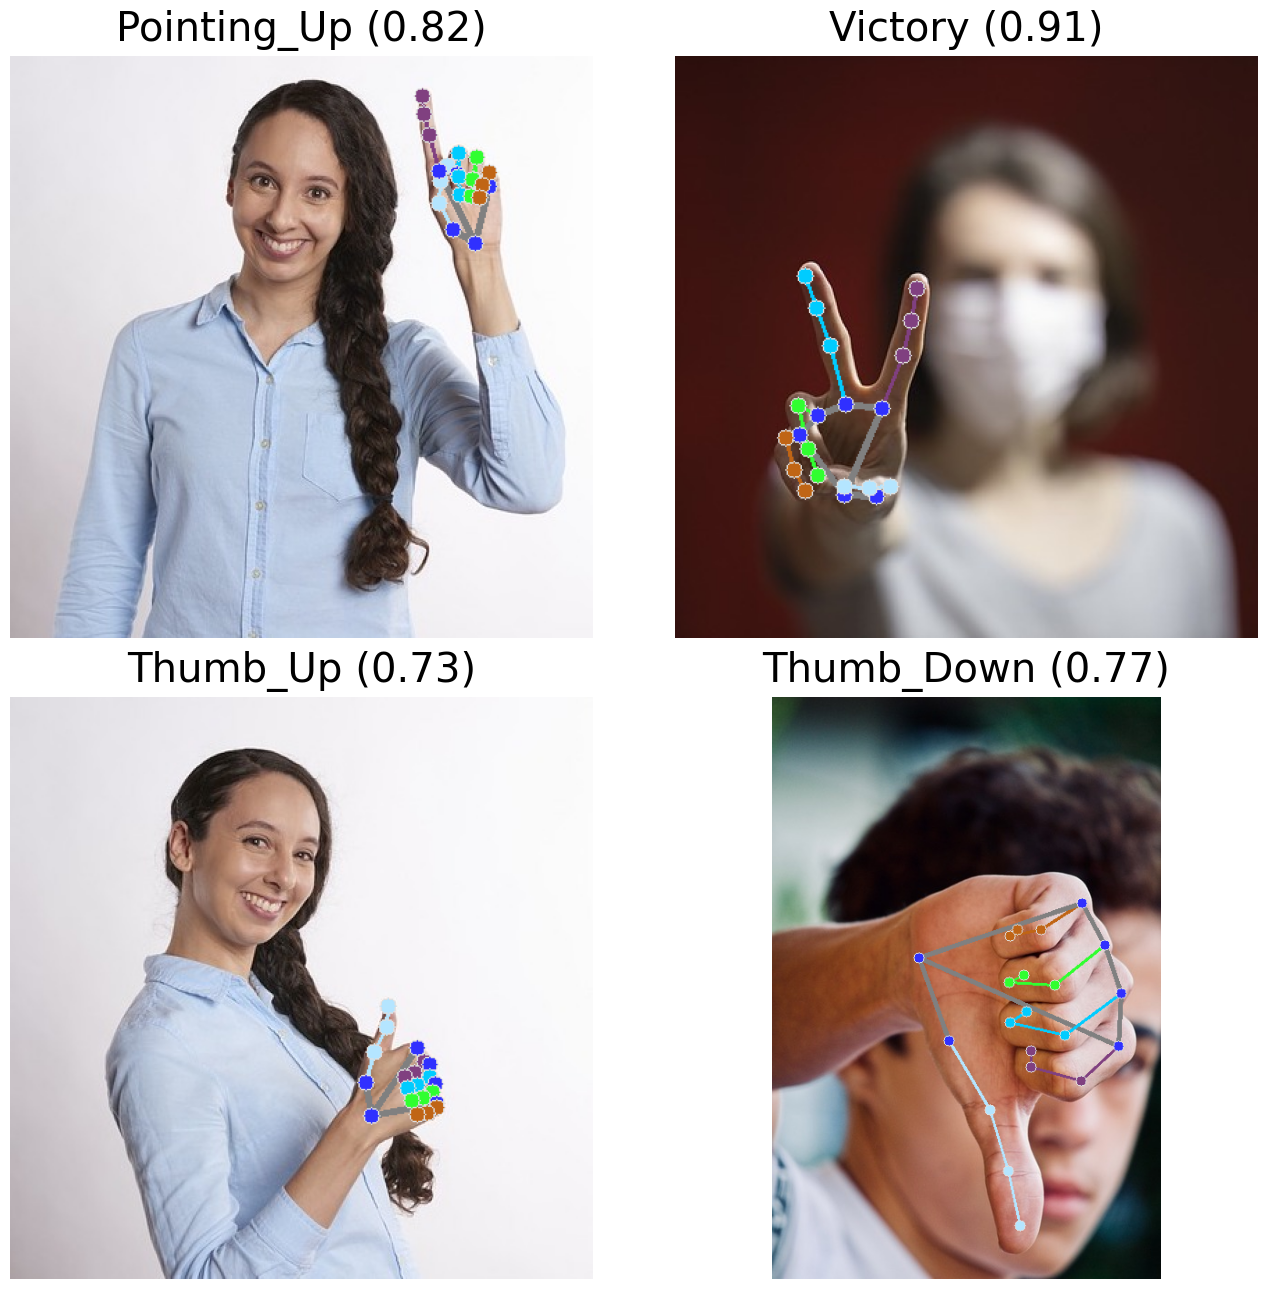

In [14]:
# STEP 1: Import the necessary modules.
import os
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an GestureRecognizer object.
base_options = python.BaseOptions(model_asset_path='gesture_recognizer.task')
options = vision.GestureRecognizerOptions(base_options=base_options)
recognizer = vision.GestureRecognizer.create_from_options(options)
IMAGE_FILENAMES = [os.path.join("gestures", image_file_name) for image_file_name in os.listdir("gestures")]

images = []
results = []
for image_file_name in IMAGE_FILENAMES:
  # STEP 3: Load the input image.
  image = mp.Image.create_from_file(image_file_name)

  # STEP 4: Recognize gestures in the input image.
  recognition_result = recognizer.recognize(image)

  # STEP 5: Process the result. In this case, visualize it.
  images.append(image)
  top_gesture = recognition_result.gestures[0][0]
  hand_landmarks = recognition_result.hand_landmarks
  results.append((top_gesture, hand_landmarks))

display_batch_of_images_with_gestures_and_hand_landmarks(images, results)

In [ ]:
# STEP 1: Import the necessary modules.
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

BaseOptions = mp.tasks.BaseOptions
GestureRecognizer = mp.tasks.vision.GestureRecognizer
GestureRecognizerOptions = mp.tasks.vision.GestureRecognizerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a gesture recognizer instance with the video mode
options = GestureRecognizerOptions(
    base_options=BaseOptions(model_asset_path='gesture_recognizer.task'),
    running_mode=VisionRunningMode.VIDEO)
with GestureRecognizer.create_from_options(options) as recognizer:
    images = []
    results = []
    vc = cv2.VideoCapture("gesture_example.avi")  # 导入的视频数据所在路径
    frame_timestamp_ms = 33
    for i in range(100): # 可视化前30帧
        (ret, frame) = vc.read()    #  读取当前帧
        # 所有帧都读取完毕，结束循环
        if not ret:
            break
        # Convert the frame received from OpenCV to a MediaPipe's Image object
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
        recognition_result = recognizer.recognize_for_video(mp_image, frame_timestamp_ms*(i+1))
        # STEP 5: Process the result. In this case, visualize it.
        images.append(mp_image)
        hand_landmarks = recognition_result.hand_landmarks
        results.append(hand_landmarks)
display_batch_of_images_with_hand_landmarks(images, results)

I0000 00:00:1713877738.630606       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3
W0000 00:00:1713877738.630924       1 gesture_recognizer_graph.cc:129] Hand Gesture Recognizer contains CPU only ops. Sets HandGestureRecognizerGraph acceleration to Xnnpack.
I0000 00:00:1713877738.631788       1 hand_gesture_recognizer_graph.cc:250] Custom gesture classifier is not defined.
